StatementMeta(, db67ac35-b98c-4d05-a8da-aeb962afebfc, 5, Finished, Available, Finished)

AIR QUALITY DASHBOARD - NYC ENVIRONMENTAL ANALYSIS (2019-2024)

Analyzing PM2.5 Trends Over Time...
Loaded 744 days of air quality data


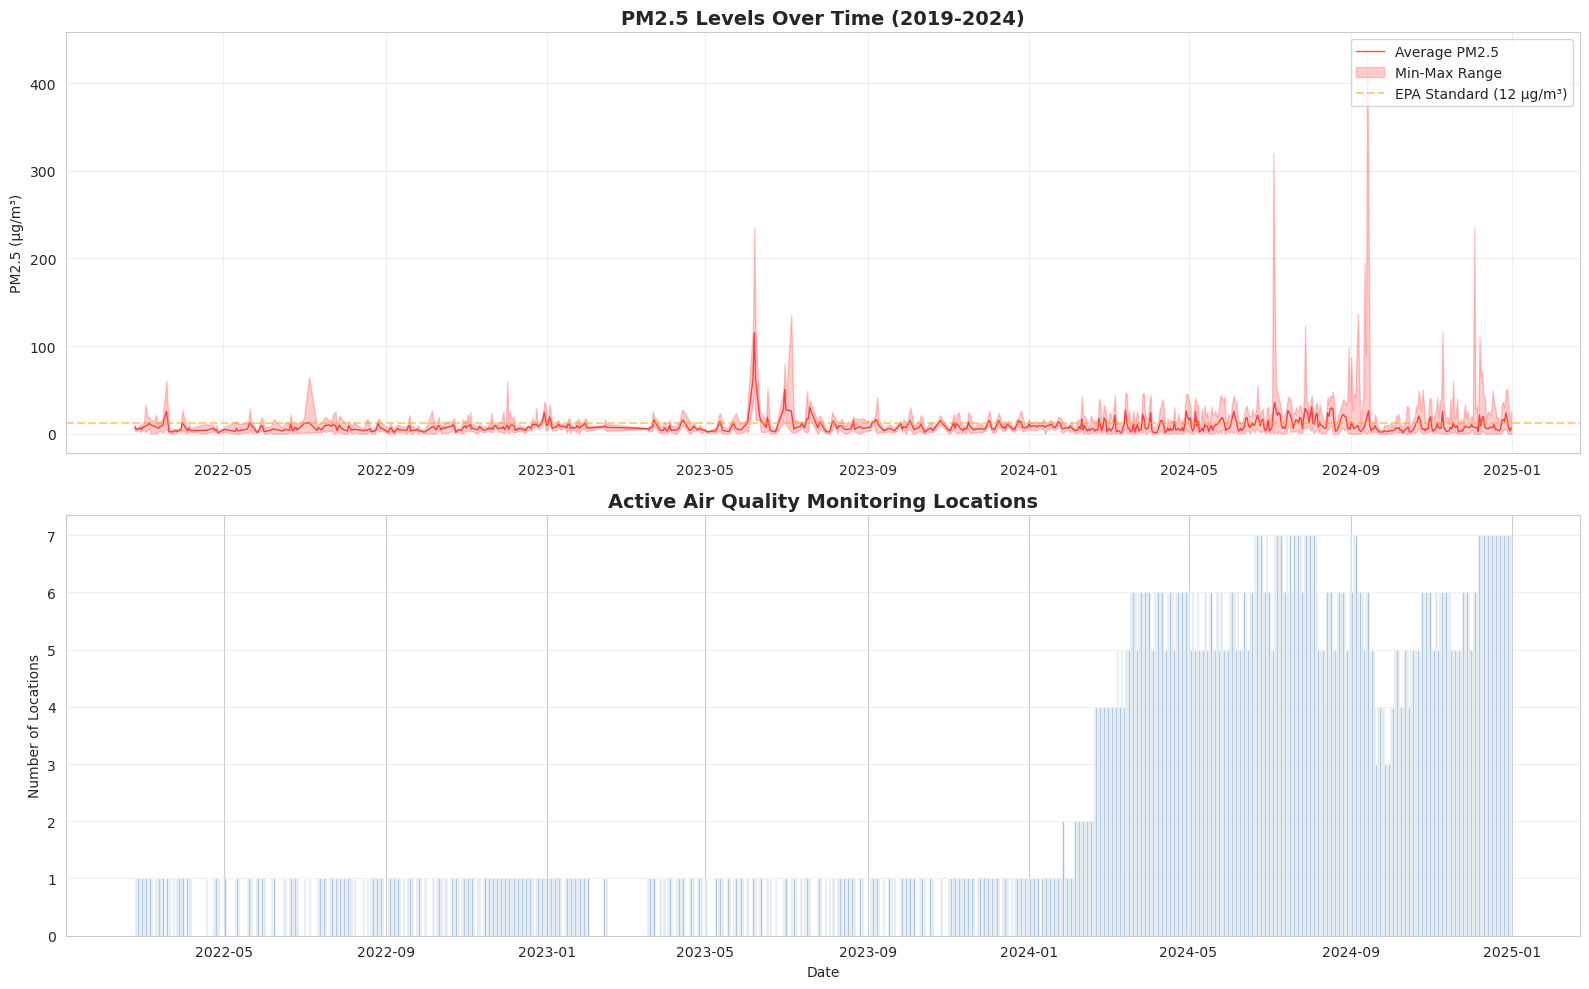


Yearly Air Quality Comparison...


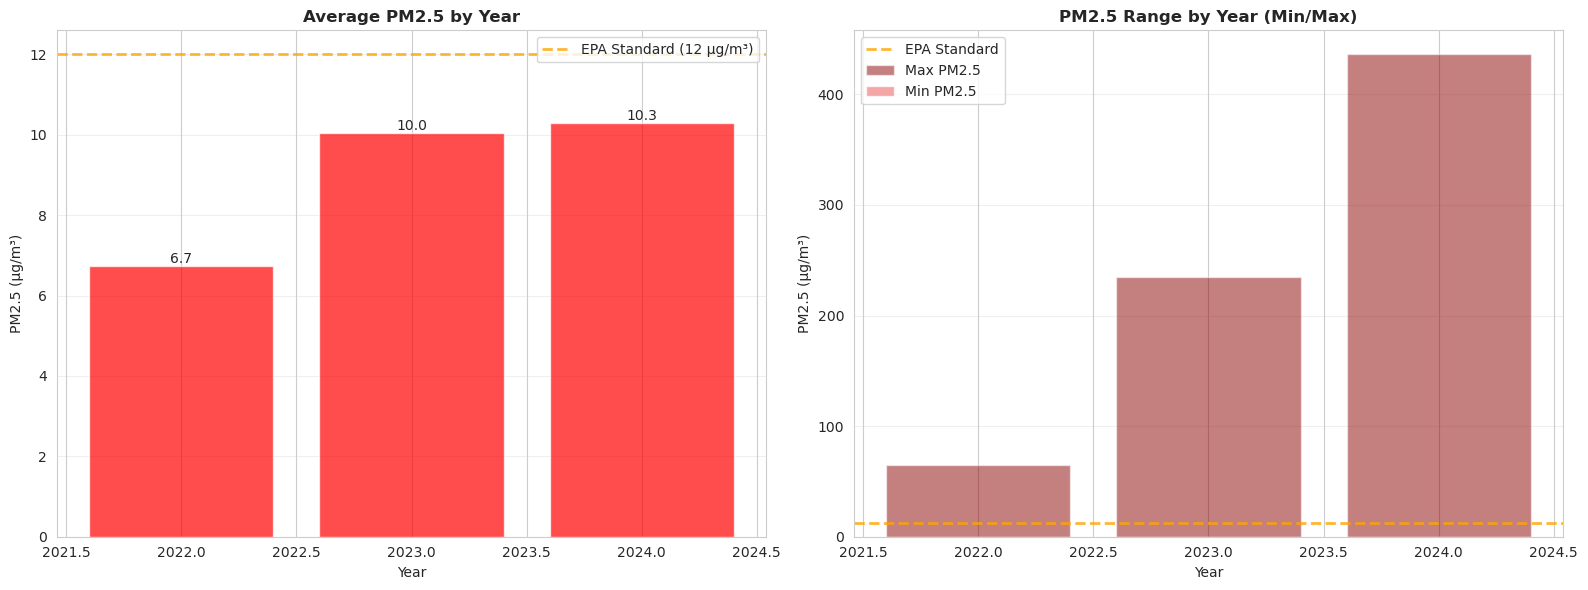


Yearly Air Quality Summary:
 Year   AvgPM25  MaxPM25  MinPM25  TotalMeasurementDays  TotalMeasurements
 2022  6.740585    65.00      0.0                   188               3991
 2023 10.037526   234.50      0.0                   194               4379
 2024 10.285166   436.07      0.0                  1810              40551

Air Quality by Location...


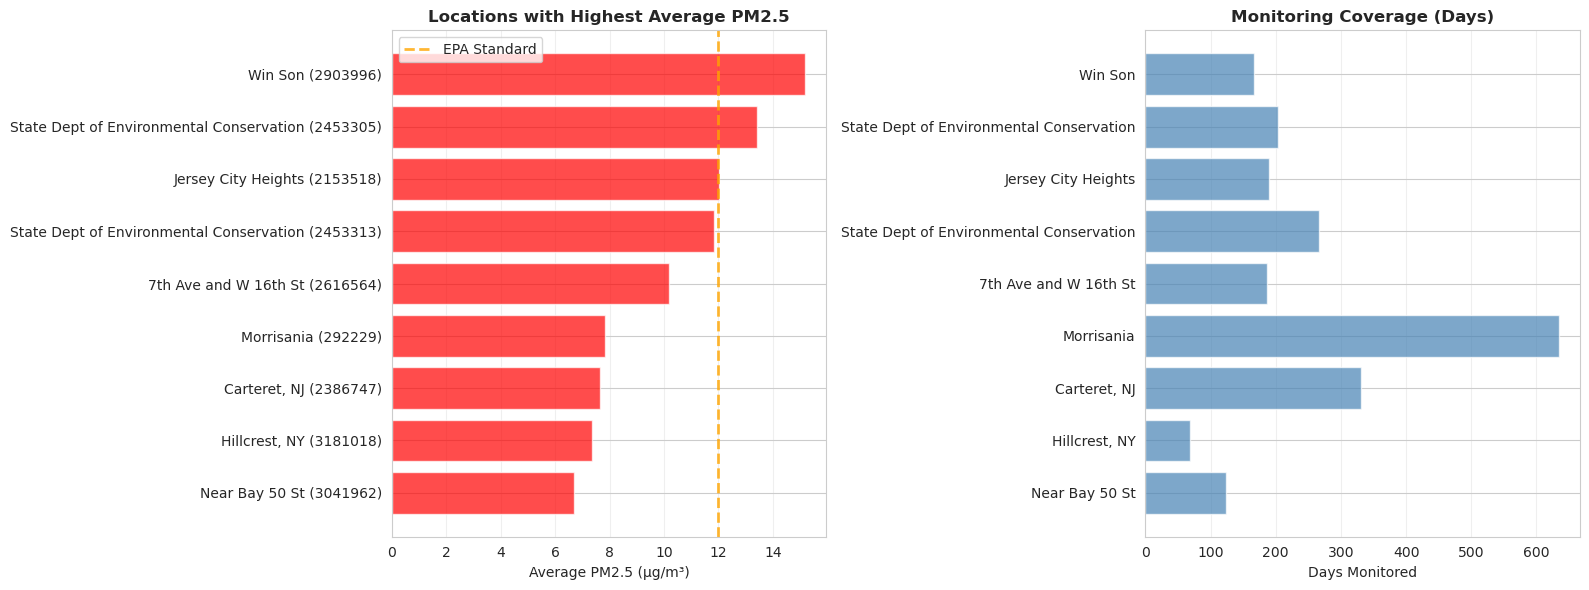


Location Summary (All Locations):
                            LocationName  LocationID   AvgPM25  MaxPM25  Days
                                 Win Son     2903996 15.195542   173.37   166
State Dept of Environmental Conservation     2453305 13.423990   436.07   203
                     Jersey City Heights     2153518 12.028466   320.03   189
State Dept of Environmental Conservation     2453313 11.824286   115.79   266
                   7th Ave and W 16th St     2616564 10.189626    97.23   187
                              Morrisania      292229  7.829228   234.50   635
                            Carteret, NJ     2386747  7.651636   130.16   330
                           Hillcrest, NY     3181018  7.343382    97.66    68
                          Near Bay 50 St     3041962  6.701707   234.42   123

Seasonal Air Quality Patterns...


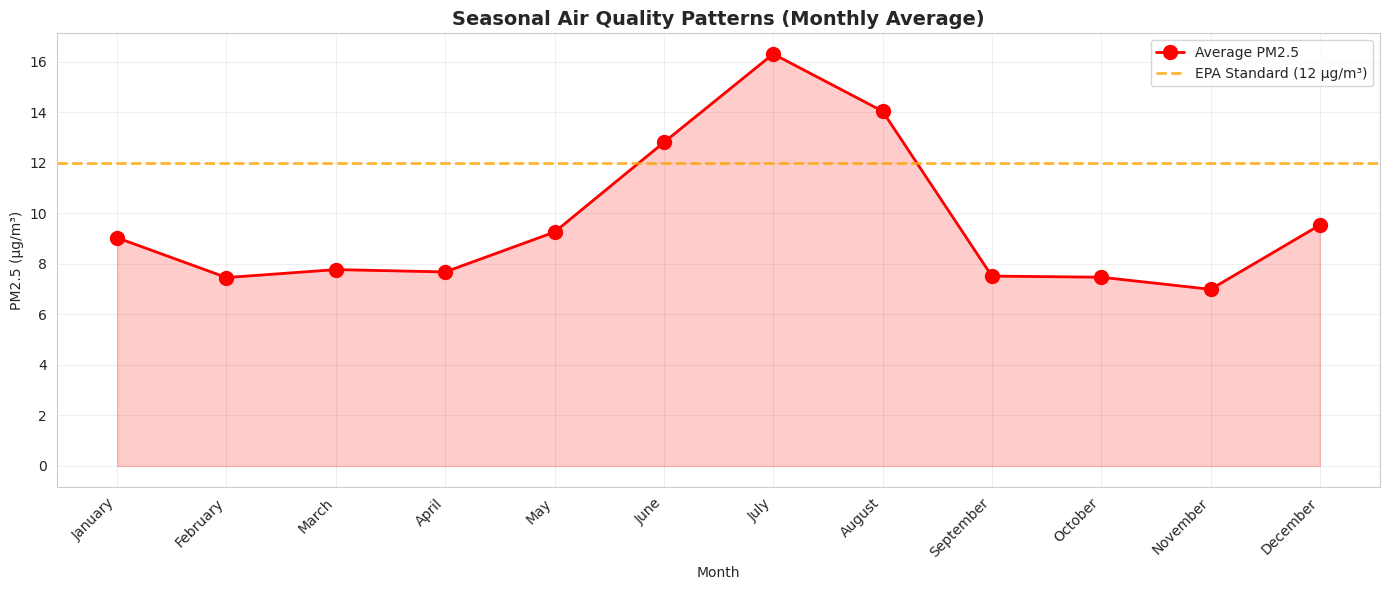


Seasonal Patterns:
 Month MonthName   AvgPM25  MaxPM25  Days
     1   January  9.032909    33.40    55
     2  February  7.458929    42.54    84
     3     March  7.773132    60.60   182
     4     April  7.681472    45.94   197
     5       May  9.258438    44.49   192
     6      June 12.808768   234.50   203
     7      July 16.311179   320.03   229
     8    August 14.045407    98.60   209
     9 September  7.516354   436.07   181
    10   October  7.471838    51.17   185
    11  November  6.993944   115.79   213
    12  December  9.535611   234.42   262

5. COVID-19 Impact on Air Quality...

Insufficient data for COVID comparison
   Only Post-COVID (2021+) data available
   Pre-COVID (2019) and COVID (2020) data not found in dataset
   Skipping COVID-19 impact visualization...
AIR QUALITY KEY METRICS (2019-2024)

Total Days Monitored: 744
Unique Locations: 10
Total Measurements: 48,921

PM2.5 Levels:
  Average: 9.96 µg/m³
  Maximum: 436.07 µg/m³
  Minimum: 0.00 µg/m³
  EPA Standa

In [3]:
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

WAREHOUSE = "MobilityWarehouse"
                          
print("AIR QUALITY DASHBOARD - NYC ENVIRONMENTAL ANALYSIS (2019-2024)")

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("\nAnalyzing PM2.5 Trends Over Time...")

df_pollutants = spark.sql(f"""
    SELECT 
        d.Date,
        d.Year,
        d.Month,
        AVG(f.AvgPM25) as PM25,
        MAX(f.MaxPM25) as MaxPM25,
        MIN(f.MinPM25) as MinPM25,
        COUNT(DISTINCT f.LocationID) as ActiveLocations,
        SUM(f.MeasurementCount) as TotalMeasurements
    FROM `{WAREHOUSE}`.dbo.FactAirQualityDaily f
    JOIN `{WAREHOUSE}`.dbo.DimDate d ON f.DateKey = d.DateKey
    GROUP BY d.Date, d.Year, d.Month
    ORDER BY d.Date
""")

pdf_pollutants = df_pollutants.toPandas()
pdf_pollutants['Date'] = pd.to_datetime(pdf_pollutants['Date'])

for col in ['PM25', 'MaxPM25', 'MinPM25']:
    pdf_pollutants[col] = pdf_pollutants[col].astype(float)

print(f"Loaded {len(pdf_pollutants):,} days of air quality data")

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

axes[0].plot(pdf_pollutants['Date'], pdf_pollutants['PM25'], 
             linewidth=1, alpha=0.7, color='red', label='Average PM2.5')
axes[0].fill_between(pdf_pollutants['Date'], pdf_pollutants['MinPM25'], pdf_pollutants['MaxPM25'], 
                      alpha=0.2, color='red', label='Min-Max Range')
axes[0].axhline(y=12, color='orange', linestyle='--', alpha=0.5, label='EPA Standard (12 µg/m³)')
axes[0].set_title('PM2.5 Levels Over Time (2019-2024)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('PM2.5 (µg/m³)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].bar(pdf_pollutants['Date'], pdf_pollutants['ActiveLocations'], 
            width=1, alpha=0.6, color='steelblue')
axes[1].set_title('Active Air Quality Monitoring Locations', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Locations')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nYearly Air Quality Comparison...")

df_yearly_aq = spark.sql(f"""
    SELECT 
        d.Year,
        AVG(f.AvgPM25) as AvgPM25,
        MAX(f.MaxPM25) as MaxPM25,
        MIN(f.MinPM25) as MinPM25,
        COUNT(*) as TotalMeasurementDays,
        SUM(f.MeasurementCount) as TotalMeasurements
    FROM `{WAREHOUSE}`.dbo.FactAirQualityDaily f
    JOIN `{WAREHOUSE}`.dbo.DimDate d ON f.DateKey = d.DateKey
    GROUP BY d.Year
    ORDER BY d.Year
""")

pdf_yearly_aq = df_yearly_aq.toPandas()
for col in ['AvgPM25', 'MaxPM25', 'MinPM25']:
    pdf_yearly_aq[col] = pdf_yearly_aq[col].astype(float)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(pdf_yearly_aq['Year'], pdf_yearly_aq['AvgPM25'], color='red', alpha=0.7)
axes[0].axhline(y=12, color='orange', linestyle='--', linewidth=2, alpha=0.8, label='EPA Standard (12 µg/m³)')
axes[0].set_title('Average PM2.5 by Year', fontsize=12, fontweight='bold')
axes[0].set_ylabel('PM2.5 (µg/m³)')
axes[0].set_xlabel('Year')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
for _, row in pdf_yearly_aq.iterrows():
    axes[0].text(row['Year'], row['AvgPM25'], f"{row['AvgPM25']:.1f}", 
                ha='center', va='bottom', fontsize=10)

axes[1].bar(pdf_yearly_aq['Year'], pdf_yearly_aq['MaxPM25'], 
            color='darkred', alpha=0.5, label='Max PM2.5')
axes[1].bar(pdf_yearly_aq['Year'], pdf_yearly_aq['MinPM25'], 
            color='lightcoral', alpha=0.7, label='Min PM2.5')
axes[1].axhline(y=12, color='orange', linestyle='--', linewidth=2, alpha=0.8, label='EPA Standard')
axes[1].set_title('PM2.5 Range by Year (Min/Max)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('PM2.5 (µg/m³)')
axes[1].set_xlabel('Year')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nYearly Air Quality Summary:")
print(pdf_yearly_aq.to_string(index=False))

print("\nAir Quality by Location...")

df_locations = spark.sql(f"""
    SELECT 
        f.LocationID,
        f.LocationName,
        AVG(f.AvgPM25) as AvgPM25,
        MAX(f.MaxPM25) as MaxPM25,
        COUNT(*) as Days,
        SUM(f.MeasurementCount) as TotalMeasurements
    FROM `{WAREHOUSE}`.dbo.FactAirQualityDaily f
    GROUP BY f.LocationID, f.LocationName
    HAVING COUNT(*) > 50
    ORDER BY AvgPM25 DESC
""")

pdf_locations = df_locations.toPandas()
pdf_locations['AvgPM25'] = pdf_locations['AvgPM25'].astype(float)
pdf_locations['MaxPM25'] = pdf_locations['MaxPM25'].astype(float)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_pm25 = pdf_locations.nlargest(10, 'AvgPM25')
axes[0].barh(range(len(top_pm25)), top_pm25['AvgPM25'], color='red', alpha=0.7)
axes[0].set_yticks(range(len(top_pm25)))
axes[0].set_yticklabels([f"{row['LocationName']} ({row['LocationID']})" 
                         for _, row in top_pm25.iterrows()])
axes[0].axvline(x=12, color='orange', linestyle='--', linewidth=2, alpha=0.8, label='EPA Standard')
axes[0].set_title('Locations with Highest Average PM2.5', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Average PM2.5 (µg/m³)')
axes[0].invert_yaxis()
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

axes[1].barh(range(len(top_pm25)), top_pm25['Days'], color='steelblue', alpha=0.7)
axes[1].set_yticks(range(len(top_pm25)))
axes[1].set_yticklabels([f"{row['LocationName']}" for _, row in top_pm25.iterrows()])
axes[1].set_title('Monitoring Coverage (Days)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Days Monitored')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nLocation Summary (All Locations):")
print(pdf_locations[['LocationName', 'LocationID', 'AvgPM25', 'MaxPM25', 'Days']].to_string(index=False))

print("\nSeasonal Air Quality Patterns...")

df_seasonal = spark.sql(f"""
    SELECT 
        d.Month,
        d.MonthName,
        AVG(f.AvgPM25) as AvgPM25,
        MAX(f.MaxPM25) as MaxPM25,
        COUNT(*) as Days
    FROM `{WAREHOUSE}`.dbo.FactAirQualityDaily f
    JOIN `{WAREHOUSE}`.dbo.DimDate d ON f.DateKey = d.DateKey
    GROUP BY d.Month, d.MonthName
    ORDER BY d.Month
""")

pdf_seasonal = df_seasonal.toPandas()
pdf_seasonal['AvgPM25'] = pdf_seasonal['AvgPM25'].astype(float)
pdf_seasonal['MaxPM25'] = pdf_seasonal['MaxPM25'].astype(float)

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(pdf_seasonal['Month'], pdf_seasonal['AvgPM25'], 
        marker='o', linewidth=2, markersize=10, color='red', label='Average PM2.5')
ax.axhline(y=12, color='orange', linestyle='--', linewidth=2, alpha=0.8, label='EPA Standard (12 µg/m³)')
ax.fill_between(pdf_seasonal['Month'], 0, pdf_seasonal['AvgPM25'], alpha=0.2, color='red')

ax.set_title('Seasonal Air Quality Patterns (Monthly Average)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('PM2.5 (µg/m³)')
ax.set_xticks(pdf_seasonal['Month'])
ax.set_xticklabels(pdf_seasonal['MonthName'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSeasonal Patterns:")
print(pdf_seasonal.to_string(index=False))

print("\n5. COVID-19 Impact on Air Quality...")

df_covid_impact = spark.sql(f"""
    SELECT 
        CASE 
            WHEN d.Year = 2019 THEN 'Pre-COVID (2019)'
            WHEN d.Year = 2020 THEN 'COVID (2020)'
            ELSE 'Post-COVID (2021+)'
        END as Period,
        AVG(f.AvgPM25) as AvgPM25,
        MAX(f.MaxPM25) as MaxPM25,
        COUNT(*) as Days,
        COUNT(DISTINCT d.Year) as Years
    FROM `{WAREHOUSE}`.dbo.FactAirQualityDaily f
    JOIN `{WAREHOUSE}`.dbo.DimDate d ON f.DateKey = d.DateKey
    GROUP BY CASE 
        WHEN d.Year = 2019 THEN 'Pre-COVID (2019)'
        WHEN d.Year = 2020 THEN 'COVID (2020)'
        ELSE 'Post-COVID (2021+)'
    END
    ORDER BY Period
""")

pdf_covid = df_covid_impact.toPandas()
pdf_covid['AvgPM25'] = pdf_covid['AvgPM25'].astype(float)
pdf_covid['MaxPM25'] = pdf_covid['MaxPM25'].astype(float)

if len(pdf_covid) == 1:
    print(f"\nInsufficient data for COVID comparison")
    print(f"   Only {pdf_covid['Period'].iloc[0]} data available")
    print(f"   Pre-COVID (2019) and COVID (2020) data not found in dataset")
    print(f"   Skipping COVID-19 impact visualization...")
else:
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.bar(pdf_covid['Period'], pdf_covid['AvgPM25'], 
           color=['steelblue', 'orange', 'green'][:len(pdf_covid)], alpha=0.7)
    ax.axhline(y=12, color='red', linestyle='--', linewidth=2, alpha=0.8, label='EPA Standard (12 µg/m³)')
    ax.set_title('PM2.5 Levels: COVID-19 Impact', fontsize=14, fontweight='bold')
    ax.set_ylabel('Average PM2.5 (µg/m³)')
    ax.tick_params(axis='x', rotation=15)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    for i, v in enumerate(pdf_covid['AvgPM25']):
        ax.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("\nCOVID Impact Summary:")
    print(pdf_covid.to_string(index=False))

print("AIR QUALITY KEY METRICS (2019-2024)")

summary = spark.sql(f"""
    SELECT 
        COUNT(DISTINCT f.DateKey) as TotalDays,
        COUNT(DISTINCT f.LocationID) as UniqueLocations,
        SUM(f.MeasurementCount) as TotalMeasurements,
        AVG(f.AvgPM25) as AvgPM25,
        MAX(f.MaxPM25) as MaxPM25,
        MIN(f.MinPM25) as MinPM25
    FROM `{WAREHOUSE}`.dbo.FactAirQualityDaily f
""").toPandas()

for col in ['AvgPM25', 'MaxPM25', 'MinPM25']:
    summary[col] = summary[col].astype(float)

print(f"\nTotal Days Monitored: {summary['TotalDays'].iloc[0]:,}")
print(f"Unique Locations: {summary['UniqueLocations'].iloc[0]:,}")
print(f"Total Measurements: {summary['TotalMeasurements'].iloc[0]:,}")
print(f"\nPM2.5 Levels:")
print(f"  Average: {summary['AvgPM25'].iloc[0]:.2f} µg/m³")
print(f"  Maximum: {summary['MaxPM25'].iloc[0]:.2f} µg/m³")
print(f"  Minimum: {summary['MinPM25'].iloc[0]:.2f} µg/m³")
print(f"  EPA Standard: 12.0 µg/m³")
print(f"  Status: {'Below Standard' if summary['AvgPM25'].iloc[0] < 12 else 'Above Standard'}")

print("AIR QUALITY DASHBOARD COMPLETE")